In [1]:
! nvidia-smi

Wed Feb 24 16:17:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
import torchvision

In [4]:
trainingdata = torchvision.datasets.MNIST('./MNIST',train=True, transform=torchvision.transforms.ToTensor(), download=True)
testdata = torchvision.datasets.MNIST('./MNIST',train=False, transform=torchvision.transforms.ToTensor(), download=True)

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
print(len(trainingdata), len(testdata))

60000 10000


torch.Size([1, 28, 28]) 8


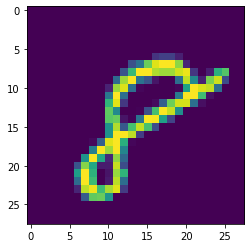

In [10]:
image, label = trainingdata[59999]
print(image.shape, label)

plt.imshow(image.squeeze().numpy())
plt.show()

In [11]:
traindataloader = torch.utils.data.DataLoader(trainingdata, batch_size=64, shuffle=True)
testdataloader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=False)

In [16]:
images, labels = iter(traindataloader).next()
print(images.size(), labels)

torch.Size([64, 1, 28, 28]) tensor([6, 9, 5, 7, 1, 9, 2, 8, 4, 5, 5, 8, 0, 9, 9, 9, 6, 3, 0, 4, 6, 3, 7, 2,
        5, 5, 3, 1, 9, 6, 8, 9, 9, 4, 2, 7, 2, 4, 2, 4, 7, 8, 6, 5, 0, 9, 4, 0,
        9, 4, 5, 4, 5, 1, 7, 2, 4, 6, 0, 8, 9, 7, 9, 2])


In [18]:
class LR(torch.nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        self.linear1 = torch.nn.Linear(28*28, 128) # W:784x128 , b:128x1 , parameters = [W,b]
        self.linear2 = torch.nn.Linear(128, 10)
    
    def forward(self, x):
        x = x.view(-1,28*28)
        transformed_x1 = self.linear1(x)
        transformed_x2 = self.linear2(transformed_x1)
        return transformed_x2
net = LR().cuda()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [19]:
train_loss_history = []
test_loss_history = []

for epoch in range(20):
    train_loss = 0.0
    test_loss = 0.0
    for i, data in enumerate(traindataloader):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        predicted_output = net(images)
        loss = criterion(predicted_output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    for i, data in enumerate(testdataloader):
        with torch.no_grad():
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            predicted_output = net(images)
            loss = criterion(predicted_output, labels)
            test_loss += loss.item()
    train_loss = train_loss/len(traindataloader)
    test_loss = test_loss/len(testdataloader)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    print('Epoch %s finished with train loss %s and test loss %s'%(epoch, train_loss, test_loss))

Epoch 0 finished with train loss 1.0787747574767579 and test loss 0.5393653278517875
Epoch 1 finished with train loss 0.4735921543957328 and test loss 0.39646133358121677
Epoch 2 finished with train loss 0.3919314584974795 and test loss 0.35222991309158364
Epoch 3 finished with train loss 0.35903996639033114 and test loss 0.32994120043649033
Epoch 4 finished with train loss 0.3405328705223766 and test loss 0.3163745865273248
Epoch 5 finished with train loss 0.3284131602993779 and test loss 0.3075468081767392
Epoch 6 finished with train loss 0.31956984421242274 and test loss 0.3024480513587689
Epoch 7 finished with train loss 0.31256831040196836 and test loss 0.29671551495980303
Epoch 8 finished with train loss 0.3069480073842794 and test loss 0.29247235780830977
Epoch 9 finished with train loss 0.30237904564340484 and test loss 0.2899073371960289
Epoch 10 finished with train loss 0.2983993410603451 and test loss 0.28769470043005835
Epoch 11 finished with train loss 0.29518236690905814 

In [21]:
predicted_output = net(images)
print(predicted_output[1])
print(torch.max(predicted_output, 1)[1])
loss = criterion(predicted_output, labels)
print(labels)
print(loss)

tensor([-4.8922, -3.3175,  7.2068,  3.3847, -3.6616, -0.4039, -4.3133,  1.4494,
         4.2532,  0.5469], device='cuda:0', grad_fn=<SelectBackward>)
tensor([1, 2, 8, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor(0.1228, device='cuda:0', grad_fn=<NllLossBackward>)
